Braki w danych:
 condition               1601
buildingMaterial         939
floor                    364
type                     350
buildYear                294
hasElevator               90
floorCount                21
clinicDistance            14
collegeDistance           11
id                         0
hasStorageRoom             0
hasSecurity                0
hasBalcony                 0
hasParkingSpace            0
ownership                  0
pharmacyDistance           0
postOfficeDistance         0
restaurantDistance         0
kindergartenDistance       0
city                       0
schoolDistance             0
poiCount                   0
centreDistance             0
longitude                  0
latitude                   0
rooms                      0
squareMeters               0
price                      0
dtype: int64


condition               1601
buildingMaterial         939
floor                    364
type                     350
buildYear                294
hasElevator               90
floorCount                21
clinicDistance            14
collegeDistance           11
id                         0
hasStorageRoom             0
hasSecurity                0
hasBalcony                 0
hasParkingSpace            0
ownership                  0
pharmacyDistance           0
postOfficeDistance         0
restaurantDistance         0
kindergartenDistance       0
city                       0
schoolDistance             0
poiCount                   0
centreDistance             0
longitude                  0
latitude                   0
rooms                      0
squareMeters               0
price                      0
dtype: int64

/var/folders/pz/zkbcmpks3m370hyv10zy19z00000gn/T/ipykernel_42852/302503436.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wroclaw_data['price_per_m2'] = wroclaw_data['price'] / wroclaw_data['squareMeters']
/var/folders/pz/zkbcmpks3m370hyv10zy19z00000gn/T/ipykernel_42852/302503436.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wroclaw_data = wroclaw_data.replace({"yes": 1, "no": 0})


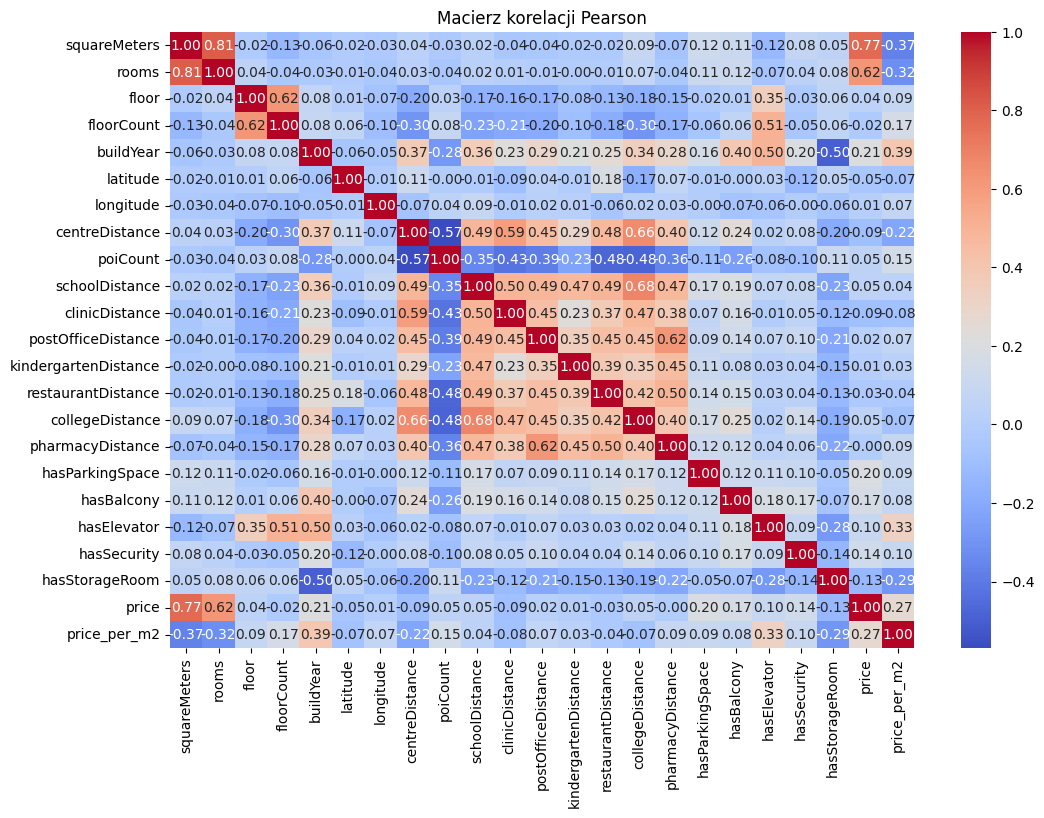

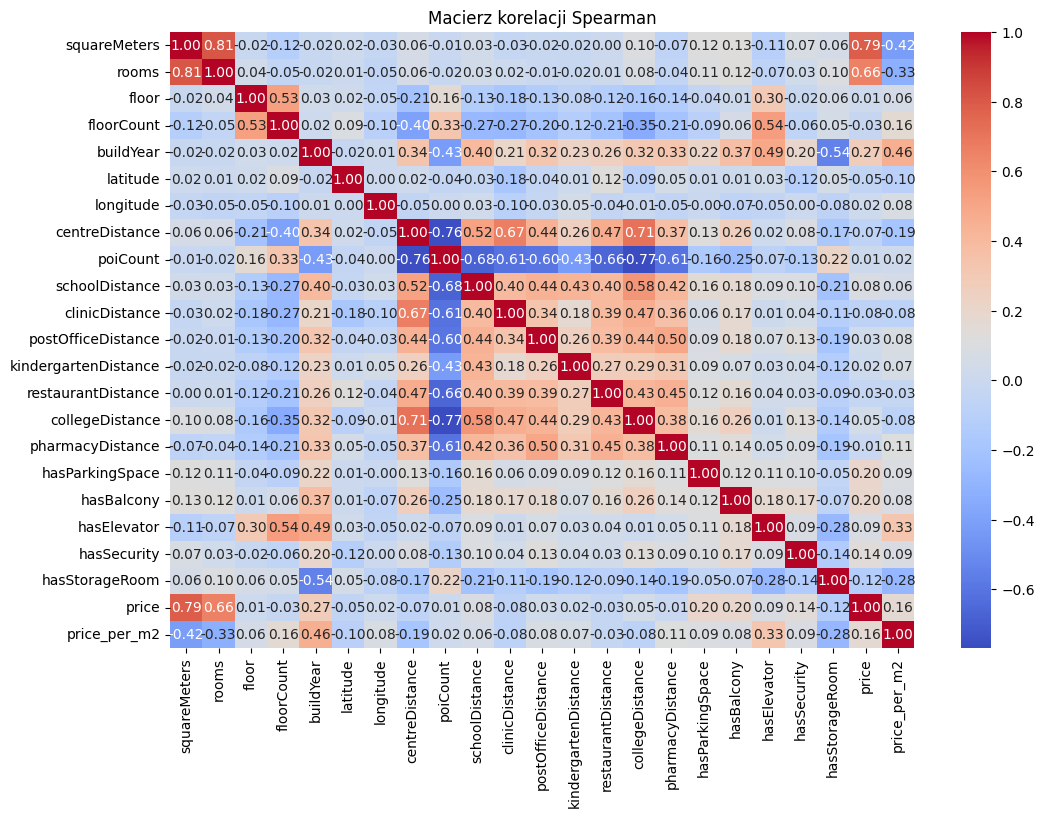

Root Mean Squared Error (RMSE): 27400.30199802897
Mean Absolute Error (MAE): 14177.575
R-squared (R²): 0.9860663551268053
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 700, 'subsample': 0.8}
Optimized Root Mean Squared Error (RMSE): 16044.631156858171
Optimized Mean Absolute Error (MAE): 7869.904258241758
Optimized R-squared (R²): 0.9952223589900427


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'apartments_pl_2024_06.csv'
data = pd.read_csv(file_path)

wroclaw_data = data[data['city'].str.lower() == 'wroclaw']

missing_data = wroclaw_data.isnull().sum().sort_values(ascending=False)
print("Braki w danych:\n", missing_data)
display(missing_data)

wroclaw_data['price_per_m2'] = wroclaw_data['price'] / wroclaw_data['squareMeters']
wroclaw_data = wroclaw_data.replace({"yes": 1, "no": 0})

correlation_matrix = wroclaw_data.corr(numeric_only=True)
correlation_matrix_spearman = wroclaw_data.corr(numeric_only=True, method="spearman")

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Macierz korelacji Pearson")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Macierz korelacji Spearman")
plt.show()

features = ['squareMeters','rooms','floor','floorCount','buildYear','latitude','longitude',
             'centreDistance','poiCount','schoolDistance','clinicDistance','postOfficeDistance',
             'kindergartenDistance','restaurantDistance','collegeDistance','pharmacyDistance',
            'hasParkingSpace','hasBalcony','hasElevator','hasSecurity',
             'hasStorageRoom', 'price_per_m2']

target = 'price'

# Handle missing values
for feature in features:
    if wroclaw_data[feature].isnull().sum() > 0:
        wroclaw_data[feature] = wroclaw_data[feature].fillna(wroclaw_data[feature].median())

X = wroclaw_data[features]
y = wroclaw_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model with manually chosen parameters
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Użyj GridSearchCV, aby znaleźć najlepsze parametry
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Trenuj GridSearch
grid_search.fit(X_train, y_train)

# Najlepsze parametry
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Zbuduj model z najlepszymi parametrami
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Ewaluacja modelu
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Optimized Root Mean Squared Error (RMSE):", rmse_best)
print("Optimized Mean Absolute Error (MAE):", mae_best)
print("Optimized R-squared (R²):", r2_best)
